# Enhancing AdaFace: A Comprehensive Analysis and Improvement of Facial Recognition Framework

by: Hossein Shams, Amir Mohammad Haghighi rad

# **Install necessary libraries**

In [ ]:
# Install PyTorch Lightning for training and model handling
!pip install -q pytorch-lightning==1.8.6
# Install the 'net' library, which includes necessary network definitions
!pip install net
# Install additional dependencies, including 'albumentations' for image augmentation
!pip install net albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.9 MB/s eta 0:00:00


# **Clone the AdaFace repository**

In [ ]:
# Clone the official AdaFace GitHub repository for access to the implementation
!git clone https://github.com/mk-minchul/AdaFace
# Change the working directory to the AdaFace folder
%cd AdaFace

Cloning into 'AdaFace'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 236 (delta 67), reused 57 (delta 57), pack-reused 127 (from 1)
Receiving objects: 100% (236/236), 38.95 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Updating files: 100% (87/87), done.
/content/AdaFace


# **Import required libraries**

In [ ]:
# Import essential Python libraries and modules for model building and inference
import os  # For file and directory operations
import net  # Custom library for network definitions
import torch  # PyTorch for deep learning
import gdown  # For downloading files from Google Drive
import numpy as np  # For numerical computations
from face_alignment import align  # For face alignment preprocessing
from torchvision import transforms  # For image transformations
from inference import load_pretrained_model, to_input  # Pre-trained model utilities
import torch.nn as nn  # For defining neural networks
import torch.nn.functional as F  # For additional neural network operations
import random  # For random number generation
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
from sklearn.metrics import roc_curve  # For ROC curve calculation
from PIL import Image  # For image handling
import pandas as pd  # Import for saving results as CSV
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

# **Download the pre-trained AdaFace model**

In [ ]:
# Create a directory to store pre-trained models
!mkdir -p pretrained
# Define the Google Drive URL for the pre-trained model checkpoint
url = "https://drive.google.com/uc?id=1eUaSHG4pGlIZK7hBkqjyp2fc2epKoBvI"
# Define the output path for the downloaded checkpoint file
output = "pretrained/adaface_ir50_ms1mv2.ckpt"
# Download the model checkpoint file using gdown
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1eUaSHG4pGlIZK7hBkqjyp2fc2epKoBvI
From (redirected): https://drive.google.com/uc?id=1eUaSHG4pGlIZK7hBkqjyp2fc2epKoBvI&confirm=t&uuid=5cb9907d-da20-4736-9aaa-022d5a24f623
To: /content/AdaFace/pretrained/adaface_ir50_ms1mv2.ckpt
100%|██████████| 700M/700M [00:15<00:00, 46.4MB/s]


'pretrained/adaface_ir50_ms1mv2.ckpt'

# **Define utility classes and functions**

<ipython-input-31-096da823801b>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pretrained/adaface_ir50_ms1mv2.ckpt', map_location=torch.device('

Model loaded successfully with adjusted state_dict.
Optimal Threshold: 0.9270789623260498


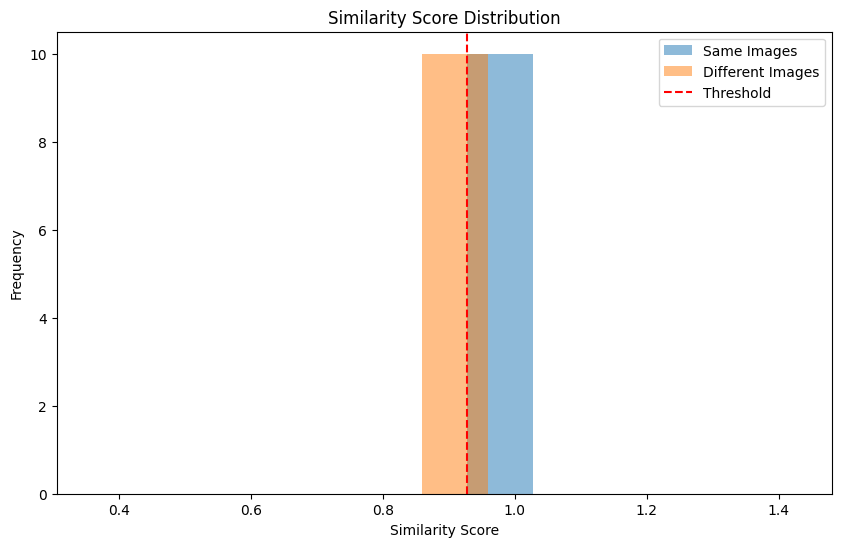

Efficiency metrics saved to efficiency_results.csv

Classification Results
Same images:
  Mean Similarity = 0.927
  Std Dev = 0.000
  Classification = Same Person

Different images:
  Mean Similarity = 0.860
  Std Dev = 0.000
  Classification = Different Person


Generating Plots


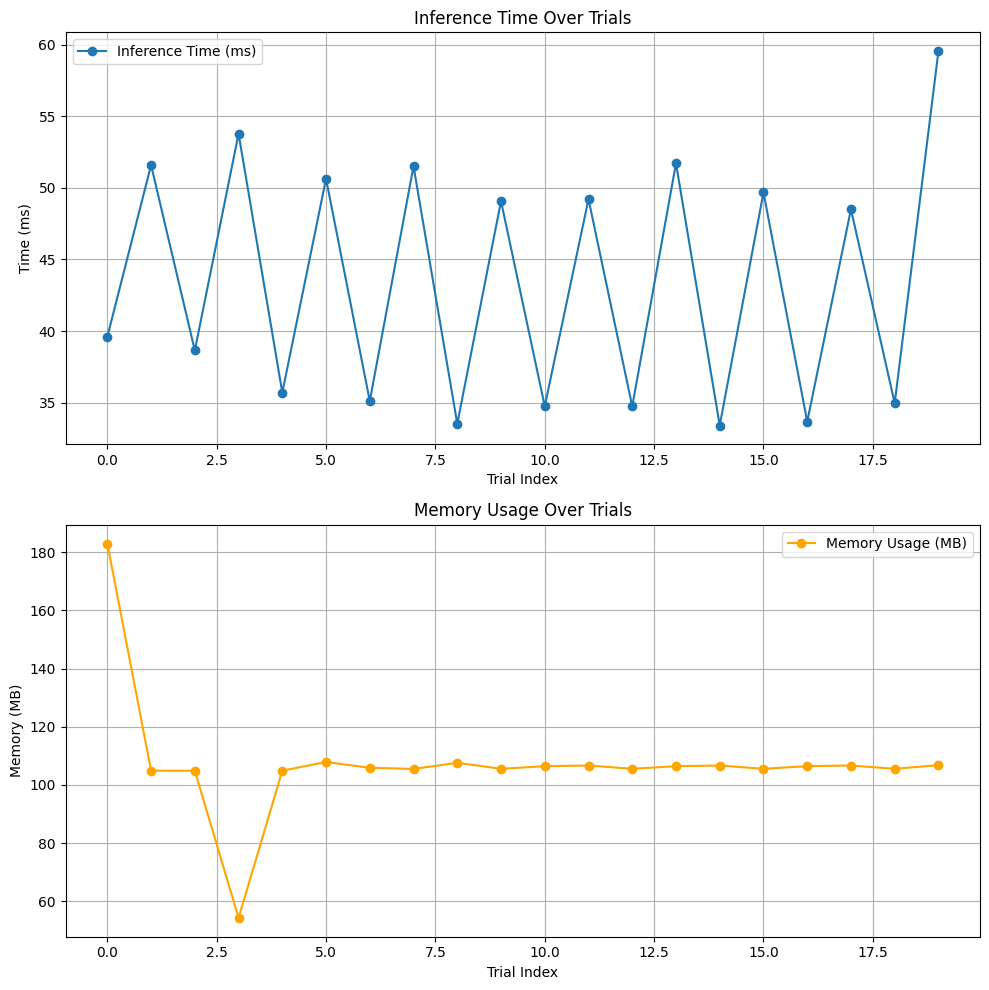

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Set seed for reproducibility of results
def set_seed(seed):
    # Set seed for random number generation in Python
    random.seed(seed)
    # Set seed for NumPy's random number generator
    np.random.seed(seed)
    # Set seed for PyTorch's random number generator (CPU)
    torch.manual_seed(seed)
    # Set seed for PyTorch's random number generator (GPU) if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Call the seed-setting function with a fixed seed value
set_seed(42)

# Define the AttentionWeightedFusion class for feature fusion
class AttentionWeightedFusion(nn.Module):
    def __init__(self, num_layers, feature_dim):
        super(AttentionWeightedFusion, self).__init__()
        # Trainable attention weights for combining multiple feature layers
        self.attention_weights = nn.Parameter(torch.ones(num_layers, requires_grad=True))
        self.fc = None  # Fully connected layer initialized dynamically
        self.feature_dim = feature_dim  # Target feature dimension after fusion

    def forward(self, features):
        # Normalize attention weights to sum to 1
        normalized_weights = F.softmax(self.attention_weights, dim=0)
        # Apply attention weights to the features and concatenate them
        weighted_features = [w * f for w, f in zip(normalized_weights, features)]
        fused_feature = torch.cat(weighted_features, dim=1)

        # Dynamically initialize the fully connected layer based on input dimension
        if self.fc is None:
            input_dim = fused_feature.shape[1]
            self.fc = nn.Linear(input_dim, self.feature_dim).to(fused_feature.device)

        # Debugging: Print the shape of the fused feature
        #print(f"Fused feature shape: {fused_feature.shape}")
        # Refine the fused feature using the fully connected layer and normalize
        refined_feature = self.fc(fused_feature)
        return F.normalize(refined_feature, p=2, dim=1)

# Define the MultiScaleAggregation class for multi-scale feature aggregation
class MultiScaleAggregation(nn.Module):
    def __init__(self, feature_dim):
        super(MultiScaleAggregation, self).__init__()
        # Define adaptive average pooling layers with different scales
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool3 = nn.AdaptiveAvgPool2d(3)
        # Fully connected layer to process aggregated features
        self.fc = nn.Linear(feature_dim * (1 + 4 + 9), feature_dim)

    def forward(self, feature_map):
        # Apply pooling at different scales and flatten the results
        pooled1 = self.pool1(feature_map).flatten(start_dim=1)
        pooled2 = self.pool2(feature_map).flatten(start_dim=1)
        pooled3 = self.pool3(feature_map).flatten(start_dim=1)
        # Concatenate the pooled features from all scales
        aggregated_feature = torch.cat([pooled1, pooled2, pooled3], dim=1)
        # Debugging: Print the shape of the aggregated feature
        #print(f"Aggregated feature shape: {aggregated_feature.shape}")
        # Refine the aggregated feature using the fully connected layer and normalize
        refined_feature = self.fc(aggregated_feature)
        return F.normalize(refined_feature, p=2, dim=1)

# Define a function to extract features with fusion
# This uses hooks to capture intermediate layer outputs
def extract_features_with_fusion(model, input_tensor, layers=['body.15', 'body.20']):
    features = []  # List to store extracted features
    hooks = {}  # Dictionary to store hooks for specified layers

    # Define a hook function to capture layer outputs
    def hook_fn(module, input, output):
        features.append(output)

    # Register hooks on the specified layers
    for name, module in model.named_modules():
        if name in layers:
            hooks[name] = module.register_forward_hook(hook_fn)

    # Pass the input tensor through the model to trigger the hooks
    model(input_tensor)

    # Remove all hooks after execution
    for hook in hooks.values():
        hook.remove()

    # Raise an error if no features were captured
    if not features:
        raise ValueError("No features were captured. Check the layer names in layers.")
    return features

# Define a function to process an input image and extract features
def process_image(image_path, model, attention_fusion, aggregation):
    # Load and preprocess the image
    pil_rgb_img = Image.open(image_path).convert("RGB").resize((112, 112))
    np_img = np.array(pil_rgb_img)
    bgr_img = ((np_img[:, :, ::-1] / 255.0) - 0.5) / 0.5
    input_tensor = torch.tensor([bgr_img.transpose(2, 0, 1)]).float().to(next(model.parameters()).device)

    # Extract features from the specified layers
    features = extract_features_with_fusion(model, input_tensor)
    # Apply multi-scale aggregation to each extracted feature
    aggregated_features = [aggregation(f) for f in features]
    # Fuse the aggregated features using attention weights
    fused_feature = attention_fusion(aggregated_features)
    return fused_feature

# Define a function to load the pre-trained model
def load_pretrained_model(architecture='ir_50'):
    # Build the model architecture (e.g., IR-50 for AdaFace)
    model = net.build_model(architecture)
    # Load the pre-trained model checkpoint
    checkpoint = torch.load('pretrained/adaface_ir50_ms1mv2.ckpt', map_location=torch.device('cpu'))
    state_dict = checkpoint['state_dict']
    new_state_dict = {}
    # Adjust the state_dict keys to match the model definition
    for key, value in state_dict.items():
        new_key = key[6:] if key.startswith('model.') else key
        new_state_dict[new_key] = value

    # Load the adjusted state_dict into the model
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()  # Set the model to evaluation mode
    print("Model loaded successfully with adjusted state_dict.")
    return model

# Function to classify image pairs based on similarity scores and a manual threshold
def classify_pairs(scores, manual_threshold=0.90):
    results = {}
    margin = 0.005  # Add a small margin to account for drift

    # Loop through each pair of images
    for pair_name, scores_list in scores.items():
        mean_score = np.mean(scores_list)  # Calculate the mean similarity score
        std_score = np.std(scores_list)   # Calculate the standard deviation of scores
        # Determine classification based on mean score and threshold
        classification = "Same Person" if mean_score > manual_threshold - margin else "Different Person"
        # Store results for each pair
        results[pair_name] = {
            "mean": mean_score,
            "std": std_score,
            "classification": classification
        }
    return results

# Function to run trials with a threshold to evaluate model performance
def run_trials_with_threshold(model, image_pairs, attention_fusion, aggregation, num_trials=10):
    scores = {"same": [], "different": []}  # Initialize containers for similarity scores
    inference_times = []  # To store inference times
    memory_usages = []  # To store memory usage

    # Perform multiple trials
    for _ in range(num_trials):
        for pair_name, (img1_path, img2_path) in image_pairs.items():
            # Reset GPU peak memory stats if using GPU
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()

            # Measure memory usage before inference
            if torch.cuda.is_available():
                memory_before = torch.cuda.memory_allocated() / (1024 * 1024)  # GPU memory in MB
            else:
                process = psutil.Process()
                memory_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

            # Measure inference time
            start_time = time.time()
            feature1 = process_image(img1_path, model, attention_fusion, aggregation)
            feature2 = process_image(img2_path, model, attention_fusion, aggregation)
            similarity_score = F.cosine_similarity(feature1, feature2).item()
            end_time = time.time()

            # Measure memory usage after inference
            if torch.cuda.is_available():
                memory_after = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Peak GPU memory in MB
            else:
                process = psutil.Process()
                memory_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB

            # Store metrics
            inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
            memory_usage = max(0, memory_after - memory_before)  # Avoid negative memory usage
            if memory_usage < 0.1:  # Treat negligible memory usage as 0
                memory_usage = 0

            inference_times.append(inference_time)
            memory_usages.append(memory_usage)
            scores[pair_name].append(similarity_score)

    # Concatenate all scores and generate corresponding labels
    all_scores = scores["same"] + scores["different"]
    all_labels = [1] * len(scores["same"]) + [0] * len(scores["different"])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    optimal_idx = np.argmax(tpr - fpr)  # Find optimal threshold index
    optimal_threshold = thresholds[optimal_idx]  # Determine optimal threshold
    print(f"Optimal Threshold: {optimal_threshold}")

    # Plot similarity score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(scores["same"], bins=10, alpha=0.5, label='Same Images')  # Scores for same pairs
    plt.hist(scores["different"], bins=10, alpha=0.5, label='Different Images')  # Scores for different pairs
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Threshold')  # Mark threshold
    plt.legend()
    plt.title('Similarity Score Distribution')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.savefig('similarity_score_distribution.png')  # Save the histogram plot
    plt.show()

    # Save inference and memory results
    efficiency_results = pd.DataFrame({
        "Inference Time (ms)": inference_times,
        "Memory Usage (MB)": memory_usages
    })
    efficiency_results.to_csv('efficiency_results.csv', index=False)
    print("Efficiency metrics saved to efficiency_results.csv")

    # Classify image pairs using a manual threshold and return the structured results
    results = classify_pairs(scores, manual_threshold=0.90)

    return results


if __name__ == '__main__':
    # Set the device to GPU if available, otherwise use CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_pretrained_model('ir_50').to(device)  # Load a pretrained model

    # Define attention fusion and aggregation modules
    attention_fusion = AttentionWeightedFusion(num_layers=2, feature_dim=512).to(device)
    aggregation = MultiScaleAggregation(feature_dim=256).to(device)

    # Define image pairs for testing
    image_pairs = {
        "same": ("face_alignment/test_images/img1.jpeg", "face_alignment/test_images/img2.jpeg"),  # Pair of similar images
        "different": ("face_alignment/test_images/img1.jpeg", "face_alignment/test_images/img3.jpeg"),  # Pair of different images
    }

    # Run trials and display results
    results = run_trials_with_threshold(model, image_pairs, attention_fusion, aggregation)

    # Organize Classification Results
    print("\n" + "="*50)
    print("Classification Results")
    print("="*50)
    for pair_name, metrics in results.items():
        print(
            f"{pair_name.capitalize()} images:\n"
            f"  Mean Similarity = {metrics['mean']:.3f}\n"
            f"  Std Dev = {metrics['std']:.3f}\n"
            f"  Classification = {metrics['classification']}\n"
        )

    # Visualization Section
    print("\n" + "="*50)
    print("Generating Plots")
    print("="*50)
    import pandas as pd
    import matplotlib.pyplot as plt

    # Load the efficiency results
    efficiency_results = pd.read_csv('efficiency_results.csv')  # Read the saved CSV

    # Create a grid layout for plots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot Inference Time
    axes[0].plot(efficiency_results["Inference Time (ms)"], marker='o', label="Inference Time (ms)")
    axes[0].set_title("Inference Time Over Trials")
    axes[0].set_xlabel("Trial Index")
    axes[0].set_ylabel("Time (ms)")
    axes[0].legend()
    axes[0].grid()

    # Plot Memory Usage
    axes[1].plot(efficiency_results["Memory Usage (MB)"], marker='o', color='orange', label="Memory Usage (MB)")
    axes[1].set_title("Memory Usage Over Trials")
    axes[1].set_xlabel("Trial Index")
    axes[1].set_ylabel("Memory (MB)")
    axes[1].legend()
    axes[1].grid()

    # Adjust layout and save the plots
    plt.tight_layout()
    plt.savefig('combined_plots.png')
    plt.show()

    # Download results for Colab
    from google.colab import files
    files.download('combined_plots.png')  # Download combined plots
    files.download('efficiency_results.csv')  # Download efficiency metrics
